# MBPLS noise dependency

Having covered the first principles of MBPLS, this notebook intends to show the influence of noise on the MBPLS-models, both in the latent variable space as well as in the resulting prediction.

## To start with, we set the parameters and generate a dataset without noise.

In [51]:
rand_seed = 25
num_samples = 100
num_vars_x1 = 15
num_vars_x2 = 15

In [52]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ortho_group

### Generate Loadings

In [53]:
np.random.seed(rand_seed)
p1 = np.expand_dims(np.sin(np.linspace(0, 5, num_vars_x2)), 1)
p2 = np.expand_dims(np.random.randint(0, 10, num_vars_x1), 1)

### Plot loadings
To generate some data we define two loading vectors which we will utilize to generate data for $X_1$ and $X_2$, respectively. As you can see below these loading vectors have different characterstic shapes. Further down, we will refer to these lodings as the "ground truth". 

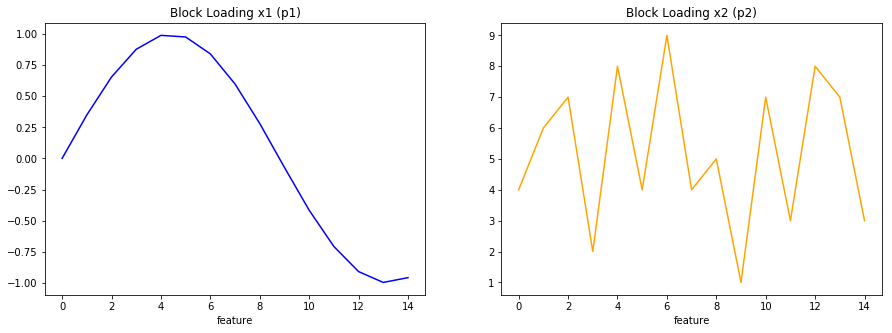

In [54]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(p1, color='blue')
ax[0].set_title('Block Loading x1 (p1)')
ax[0].set_xlabel('feature')
ax[1].plot(p2, color='orange')
ax[1].set_title('Block Loading x2 (p2)')
ax[1].set_xlabel('feature');

### Generate orthogonal scores
Here we generate some orthogonal scores. We impose orthogonality to make this analysis clear and simple. Of course, real data would typically deviate from this condition.

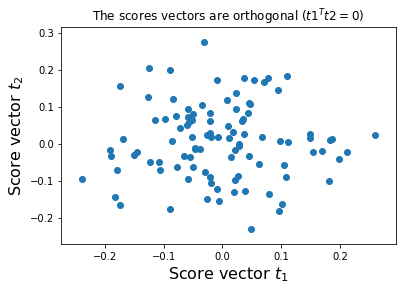

In [55]:
T = ortho_group.rvs(num_samples, random_state=rand_seed)[:, 0:2]
t1 = T[:,0:1]
t2 = T[:,1:2]

plt.figure()
plt.scatter(t1, t2)
plt.xlabel('Score vector $t_1$', size=16)
plt.ylabel('Score vector $t_2$', size=16)
plt.title('The scores vectors are orthogonal ($t1^Tt2 = 0$)');

### Generate data using loadings and scores
Two data blocks are generated. Block $X_1$ is formed as the outer vector product of loading vector $p_1$ and score vector $t_1$. Similarily, the data block $X_2$ is calculated as the outer vector product of loading vector $p_2$ and score vector $t_2$.

$ X_1 = t_1 \cdot p_1^T $

$ X_2 = t_2 \cdot p_2^T $

In [56]:
x1 = np.dot(t1, p1.T)
x2 = np.dot(t2, p2.T)

## Plot data blocks x1 and x2
Let's look at the data blocks $X_1$ and $X_2$. The variance in $X_1$ is related to the first score vector $t_1$ while the variance in $X_2$ is related to the second score vector $t_2$ 

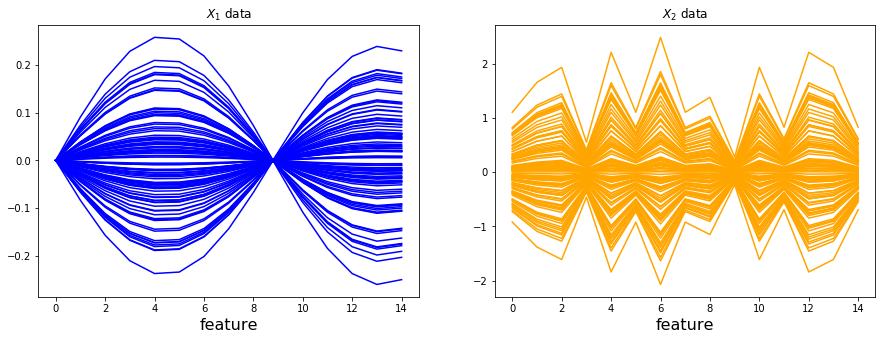

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(x1.T, color='blue') 
ax[0].set_title('$X_1$ data') 
ax[0].set_xlabel('feature', size=16)
ax[1].plot(x2.T, color='orange') 
ax[1].set_title('$X_2$ data') 
ax[1].set_xlabel('feature', size=16);

### Generate data block Y

In order to obtain a data block Y, we simply set the score block $T$, which consists of $t_1$ and $t_2$, equal to block $Y$.

In [58]:
Y = T

### Plot data block Y

Text(0.5, 0, 'feature')

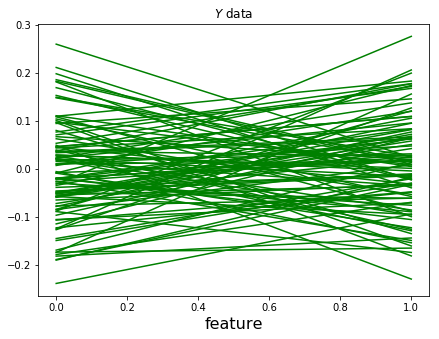

In [59]:
fig, ax = plt.subplots(ncols=1, figsize=(7,5))
ax.plot(Y.T, color='green') 
ax.set_title('$Y$ data') 
ax.set_xlabel('feature', size=16)

### With the generated data, we can derive the $\beta$ prediction coefficient vector.

To derive the $\beta$ vector, we simply run the MBPLS model.

In [60]:
from mbpls.mbpls import MBPLS
mbpls_model = MBPLS(n_components=2,method='NIPALS',standardize=True)
mbpls_model.fit(X=[x1, x2], Y=Y)

beta_1 = mbpls_model.beta_[:,0:1]
beta_2 = mbpls_model.beta_[:,1:2];

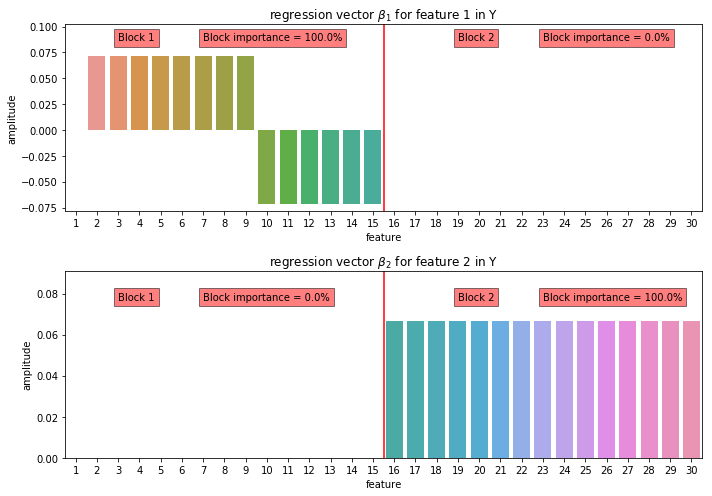

In [61]:
import seaborn as sns
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,7))
sns.barplot(x=np.arange(1, len(mbpls_model.beta_[:,0])+1), y=mbpls_model.beta_[:,0], ax=ax[0])
ax[0].set_title('regression vector $\\beta_1$ for feature 1 in Y')
ax[0].axvline(14.5, color='r')
y_lim = ax[0].get_ylim()[1]
ax[0].text(2, y_lim*1.1, 'Block 1', bbox=dict(facecolor='red', alpha=0.5))
ax[0].text(6, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,0][0])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[0].text(18, y_lim*1.1, 'Block 2', bbox=dict(facecolor='red', alpha=0.5))
ax[0].text(22, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,0][1])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[0].set_ylim(top=y_lim*1.3)
ax[0].set_xlabel('feature')
ax[0].set_ylabel('amplitude')

sns.barplot(x=np.arange(1, len(mbpls_model.beta_[:,1])+1), y=mbpls_model.beta_[:,1], ax=ax[1])
ax[1].set_title('regression vector $\\beta_2$ for feature 2 in Y')
ax[1].axvline(14.5, color='r')
y_lim = ax[1].get_ylim()[1]
ax[1].text(2, y_lim*1.1, 'Block 1', bbox=dict(facecolor='red', alpha=0.5))
ax[1].text(6, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,1][0])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[1].text(18, y_lim*1.1, 'Block 2', bbox=dict(facecolor='red', alpha=0.5))
ax[1].text(22, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,1][1])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[1].set_ylim(top=y_lim*1.3)
ax[1].set_xlabel('feature')
ax[1].set_ylabel('amplitude')
plt.tight_layout()

As expected, the resulting regression vector shows feature 1 in block $Y$ has only regression coefficients for features in block $X_1$ and that feature 2 in block $Y$ has only regression coefficients for features in block $X_2$. Expectedly, the block importances equal 100% respectively for the blocks the data was relevant.

*Note: At first this plot might look strange. However, it has to be taken into account that $\beta$ is based on the interally standardized data and that our data for now only consists of linear combinations with different scalars that, when standardized, fall back to the same value.

## Noise analysis
As the above shown plots show the ground truth and our data is analytically calculated, we now want to investigate the influence of different noise levels the behaviour of the MBPLS model. In the following we define a function, that adds a given level of noise to a dataset, so that it exhibits a defined Signal-To-Noise-Ratio (SNR).

In [62]:
def add_noise(data, snr, variable_wise=True):
    assert(snr>0), "The signal-to-noise-ration has to be higher than 0"
    snr_inverse = 1 / snr
    if variable_wise:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(data)
        noise = np.random.normal(0, np.sqrt(snr_inverse) * scaler.scale_, size=data.shape)
    else:
        std_data = data.std()
        noise = np.random.normal(0, np.sqrt(snr_inverse) * std_data, size=data.shape)
    data = data + noise
    return data

### Adding Noise to the data

We now add homoscedastic noise to the data, by creating a dataset with an overal SNR of 1. I.e. the overall dataset has a given SNR of 1, but the single variables can exhibit a different SNR. This is relevant for technical applications, where all variables have the same noise-level regardless their amplitude, e.g. due to ground noise in data transmission.

In [63]:
x1_snr_1 = add_noise(x1, 1, variable_wise=False)
x2_snr_1 = add_noise(x2, 1, variable_wise=False)

### Add noise to block Y

To create more realistic conditions, we also add some noise to $Y$. We chose a SNR of 5 for Y in this case, but it could be adjusted to any value that feels more suitable for your application.

In [64]:
Y_noise = add_noise(Y, 5, variable_wise=False)

We now run the MBPLS model again and compare generated results to the ground truth vectors from above.

In [65]:
mbpls_model.fit(X=[x1_snr_1, x2_snr_1], Y=Y_noise);

## Plot $\hat{p}_1$ and $\hat{p}_2$ and compare to ground truth loadings $p_1$ and $p_2$

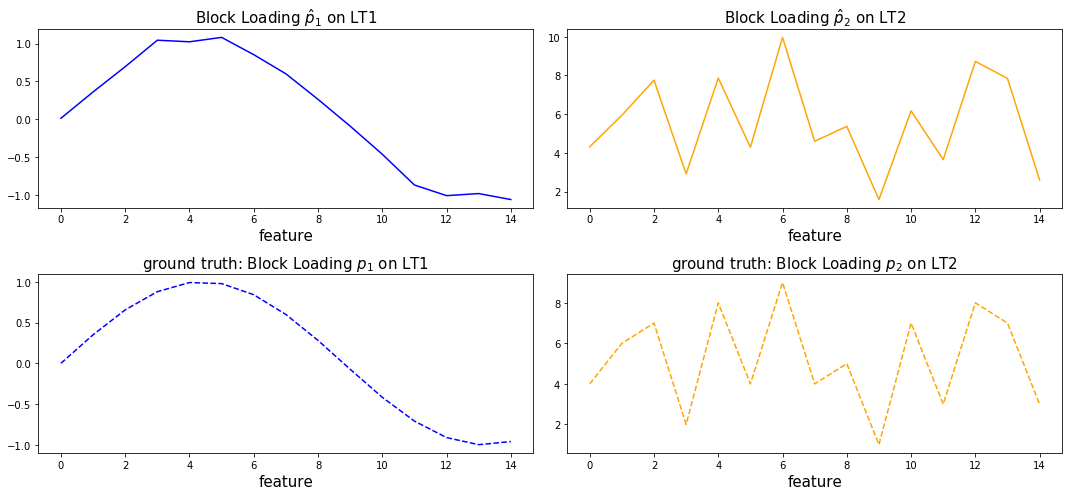

In [66]:
p1_hat = mbpls_model.P_[0][:,0]
p2_hat = mbpls_model.P_[1][:,1]

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,7))
ax[0][0].plot(mbpls_model.x_scalers_[0].inverse_transform(p1_hat), color='blue') 
ax[0][0].set_title('Block Loading $\hat{p}_1$ on LT1', size=15) 
ax[0][0].set_xlabel('feature', size=15)
ax[0][1].plot(mbpls_model.x_scalers_[1].inverse_transform(p2_hat), color='orange') 
ax[0][1].set_title('Block Loading $\hat{p}_2$ on LT2', size=15) 
ax[0][1].set_xlabel('feature', size=15)
ax[1][0].plot(p1,color='blue',ls='--') 
ax[1][0].set_title('ground truth: Block Loading $p_1$ on LT1', size=15) 
ax[1][0].set_xlabel('feature', size=15)
ax[1][1].plot(p2,color='orange',ls='--') 
ax[1][1].set_title('ground truth: Block Loading $p_2$ on LT2', size=15)
ax[1][1].set_xlabel('feature', size=15)
plt.tight_layout()

As you can see above the fitted block loadings $\hat{p}_1$ and $\hat{p}_2$ describe our original feature loadings well, even though the SNR is one. Depending on the initialization of the analysis the sign of the loading vectors might switch.

## Block scores $\hat{t}_1$ in LV1 and $\hat{t}_2$ in LV2 are highly correlated to ground truth $t_1$ and $t_2$

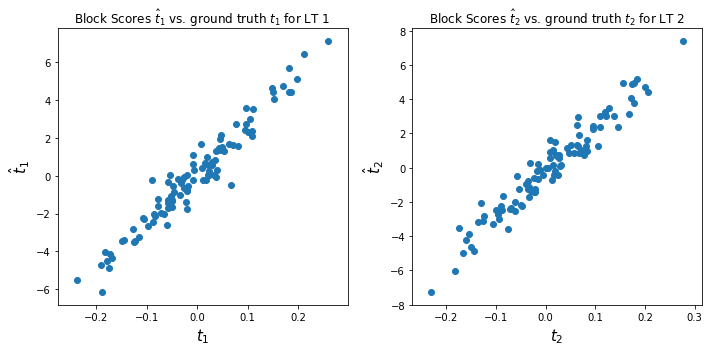

In [67]:
t1_hat = mbpls_model.T_[0][:,0]
t2_hat = mbpls_model.T_[1][:,1]
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(t1, t1_hat) 
ax[0].set_title('Block Scores $\hat{t}_1$ vs. ground truth $t_1$ for LT 1')
ax[0].set_xlabel('$t_1$', size=15)
ax[0].set_ylabel('$\hat{t}_1$', size=15)
ax[1].scatter(t2, t2_hat)
ax[1].set_title('Block Scores $\hat{t}_2$ vs. ground truth $t_2$ for LT 2')
ax[1].set_xlabel('$t_2$', size=15)
ax[1].set_ylabel('$\hat{t}_2$', size=15)
plt.tight_layout();

The same applies to the score vectors. The noise adds some spread, but the derived scores vectors are still well aligned with the original scores vectors.

## Regression vector $\hat{\beta}$

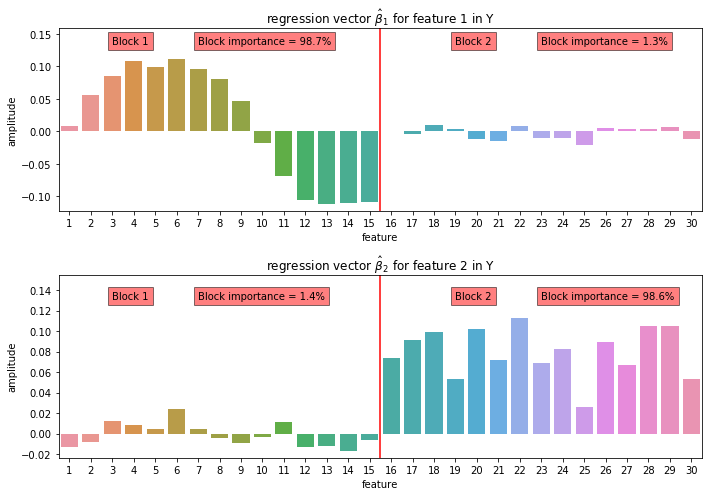

In [68]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,7))
sns.barplot(x=np.arange(1, len(mbpls_model.beta_[:,0])+1), y=mbpls_model.beta_[:,0], ax=ax[0])
ax[0].set_title('regression vector $\hat{\\beta}_1$ for feature 1 in Y')
ax[0].axvline(14.5, color='r')
y_lim = ax[0].get_ylim()[1]
ax[0].text(2, y_lim*1.1, 'Block 1', bbox=dict(facecolor='red', alpha=0.5))
ax[0].text(6, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,0][0])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[0].text(18, y_lim*1.1, 'Block 2', bbox=dict(facecolor='red', alpha=0.5))
ax[0].text(22, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,0][1])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[0].set_ylim(top=y_lim*1.3)
ax[0].set_xlabel('feature')
ax[0].set_ylabel('amplitude')

sns.barplot(x=np.arange(1, len(mbpls_model.beta_[:,1])+1), y=mbpls_model.beta_[:,1], ax=ax[1])
ax[1].set_title('regression vector $\hat{\\beta}_2$ for feature 2 in Y')
ax[1].axvline(14.5, color='r')
y_lim = ax[1].get_ylim()[1]
ax[1].text(2, y_lim*1.1, 'Block 1', bbox=dict(facecolor='red', alpha=0.5))
ax[1].text(6, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,1][0])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[1].text(18, y_lim*1.1, 'Block 2', bbox=dict(facecolor='red', alpha=0.5))
ax[1].text(22, y_lim*1.1, "Block importance = {:.1f}%".format(float(mbpls_model.A_[:,1][1])*100),
            bbox=dict(facecolor='red', alpha=0.5))
ax[1].set_ylim(top=y_lim*1.3)
ax[1].set_xlabel('feature')
ax[1].set_ylabel('amplitude')
plt.tight_layout()

Compared to the previous $\beta$ regression graph, the impact of the noise on the $\hat{\beta}$ regression vector can be seen clearly. For the first feature in $Y$, $\beta$ coefficients for features in Block $X_2$ start appearing, even though this block has no relation to feature 1 in block $Y$. Accordingly, the block importance minimally shifts towards Block $X_2$.
For the second feature in block $Y$ things look similar. Here block $X_1$ obtained small $\beta$ coefficients and the block importance slightly shifts to block $X_1$.

This motivates the simulation of different noise-levels, clearly defined as SNR (see above), to describe the stability of the MBPLS model under noisy conditions.

### Test setup and results comparison

To test the results of the MBPLS model under a wide range of noise conditions and still allow comprehensible comparison, all resulting vectors will be compared by the cosine similarity* of the resulting vector compared to the originally created vector from above for each SNR applied. To make the tests statistically sound, each SNR is simulated 20 times with newly simulated noise each time.

The vectors compared are:
* Block Loading $\hat{p}_1$ and $p_1$ on LT1
* Block Score $\hat{t}_1$ and $t_2$ on LT1
* Block Loading $\hat{p}_2$ and $p_2$ on LT2
* Block Score $\hat{t}_2$ and $t_2$ on LT2
* Regression vector $\hat{\beta}_1$ and $\beta_1$ for feature 1 in Y
* Regression vector $\hat{\beta}_2$ and $\beta_2$ for feature 2 in Y

Furthermore, the block importances of the resulting SNR are plotted, which optimally should be 1 at all times, so show the robustness of this measure.

*Note, as due to the fitting process the vectors can be switched in the opposite direction, we only take the absolute value of the cosine similiarity, in order to make it rotation invariant.

In [74]:
from scipy.spatial.distance import cosine
from scipy.stats import bayes_mvs
# Ground truth vectors t1, t2, p1, p2, beta_1 and beta_2 are calculated above
ground_truth = [t1, t2, p1, p2, beta_1, beta_2, 1, 1]
ground_truth_names = ['t_1', 't_2', 'p_1', 'p_2', '\\beta_1', '\\beta_2', 
                      'BIP_1', 'BIP_2']
SNRs = [2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 1e-6, 1e-12, 1e-16]
reruns = 20
similarity = np.zeros((len(ground_truth), len(SNRs), reruns))
mean_vec = np.zeros((len(ground_truth), len(SNRs)))
lower_cfi_vec = np.zeros((len(ground_truth), len(SNRs)))
upper_cfi_vec = np.zeros((len(ground_truth), len(SNRs)))

mbpls_model = MBPLS(n_components=2, method='NIPALS', standardize=True)
for j, SNR in enumerate(SNRs):
    for rerun in range(reruns):
        x1_snr = add_noise(x1, SNR, variable_wise=False)
        x2_snr = add_noise(x2, SNR, variable_wise=False)
        mbpls_model.fit(X=[x1_snr, x2_snr], Y=Y_noise)
        t1_hat = mbpls_model.T_[0][:,0:1]
        t2_hat = mbpls_model.T_[1][:,1:2]
        p1_hat = mbpls_model.P_[0][:,0:1]
        p2_hat = mbpls_model.P_[1][:,1:2]
        beta_1_hat = mbpls_model.beta_[:, 0:1]
        beta_2_hat = mbpls_model.beta_[:, 1:2]
        block_importance_1_hat = mbpls_model.A_[0, 0]
        block_importance_2_hat = mbpls_model.A_[1, 1]
        similarity[0, j, rerun] = np.abs(1 - cosine(t1, t1_hat))
        similarity[1, j, rerun] = np.abs(1 - cosine(t2, t2_hat))
        similarity[2, j, rerun] = np.abs(1 - cosine(p1, p1_hat))
        similarity[3, j, rerun] = np.abs(1 - cosine(p2, p2_hat))
        similarity[4, j, rerun] = 1 - cosine(beta_1, beta_1_hat)
        similarity[5, j, rerun] = 1 - cosine(beta_2, beta_2_hat)
        similarity[6, j, rerun] = block_importance_1_hat
        similarity[7, j, rerun] = block_importance_2_hat
    
    for i, vector in enumerate(ground_truth):
        mean, _, _ = bayes_mvs(similarity[i, j,:], alpha=0.95)
        mean_vec[i,j] = mean[0]
        lower_cfi_vec[i,j] = mean[1][0]
        upper_cfi_vec[i,j] = mean[1][1]


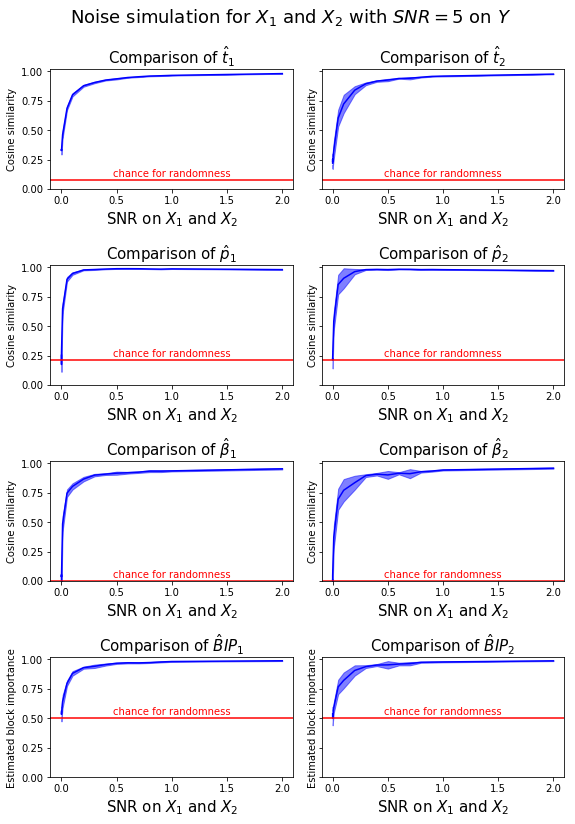

In [75]:
from scipy.stats import norm
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(8,12), sharey=True)

for i, vector in enumerate(ground_truth_names):
    ax[int(i/2)][i%2].plot(SNRs, mean_vec[i,:], color='b')
    ax[int(i/2)][i%2].fill_between(SNRs, lower_cfi_vec[i,:], upper_cfi_vec[i,:]
                                   , color='b', alpha=0.5)
    ax[int(i/2)][i%2].set_title('Comparison of $\hat{}$'.format(ground_truth_names[i]), size=15)
    ax[int(i/2)][i%2].set_xlabel('SNR on $X_1$ and $X_2$', size=15)
    ax[int(i/2)][i%2].set_ylim(bottom=0)
    aver=[]
    if 'beta' in vector:
        ax[int(i/2)][i%2].set_ylabel('Cosine similarity')
        for _ in range(20000):
            a = np.random.normal(0, 1, size=ground_truth[i].shape)
            aver.append(1-cosine(a,ground_truth[i]))
        ax[int(i/2)][i%2].axhline(np.mean(aver), color='r')
        ax[int(i/2)][i%2].text(1, np.mean(aver)+0.03, 'chance for randomness', 
                           horizontalalignment='center', color='r')
    elif 'BIP' not in vector:
        ax[int(i/2)][i%2].set_ylabel('Cosine similarity')
        for _ in range(20000):
            a = np.random.normal(0, 1, size=ground_truth[i].shape)
            aver.append(np.abs(1-cosine(a,ground_truth[i])))
        ax[int(i/2)][i%2].axhline(np.mean(aver), color='r')
        ax[int(i/2)][i%2].text(1, np.mean(aver)+0.03, 'chance for randomness', 
                               horizontalalignment='center', color='r')
    if 'BIP' in vector:
        ax[int(i/2)][i%2].set_ylabel('Estimated block importance')
        ax[int(i/2)][i%2].axhline(0.5, color='r')
        ax[int(i/2)][i%2].text(1, 0.5+0.03, 'chance for randomness', 
                               horizontalalignment='center', color='r')

plt.suptitle('Noise simulation for $X_1$ and $X_2$ with $SNR=5$ on $Y$', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The plots above show similarity of the ground truth vectors/values of the data and the estimated vectors/values of the MBPLS model ```MBPLS(n_components=2, method='NIPALS', standardize=True)``` for the corresponding SNRs. Furthermore, a read line is added to each plot indicating the chance for randomness. I.e. how well a randomnly guessed vector/value performs in 50% of all cases. Accordingly, if the model performance is at the red line, it is no better than randomnly guessing the solution.

In overall, it can be seen that the model exhibits a very robust performance even with high noise ratios on the data. As it approaches levels where the noise level is magnitudes higher than the signal level, the performance approaches randomness. It might seem confusing at first that the estimated loading vectors $\hat{p_1}$ and $\hat{p_2}$ perform even worse than random vectors, but it has to be taken into account that these are inherently related to the respective estimated score vectors, which in return always perform better than at random. Thus, the combination of the two levels out and performs as good as randomness.